In [ ]:
# Import essential libraries for data handling, visualization, and analysis
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # For creating static visualizations
import matplotlib as mpl # For uniform plot creation
import seaborn as sns # For enhanced statistical data visualization
import numpy as np # For numerical operations

# Import statistical tools
from scipy.stats import spearmanr # For computing Spearman rank correlation
from statsmodels.stats.multitest import multipletests # For multiple testing correction (e.g., FDR)
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import spearmanr

# Import scikit-learn tool for handling missing values
from sklearn.impute import SimpleImputer # For imputing missing values

# System and warning configuration
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # Prevents conflicts in certain parallel computing environments (e.g., on MacOS or when using MKL)

#Plot constants
mpl.rcParams['figure.dpi'] = 300
plt.rc('font', size=8)           # controls default text sizes
plt.rc('axes', titlesize=8)      # fontsize of the axes title
plt.rc('axes', labelsize=8)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)     # fontsize of the tick labels
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=12)    # fontsize of the figure title

In [134]:
# Define global parameters for filtering, exclusion, and reproducibility
params = {
    # Path to preprocessed machine learning-ready behavioral dataset (parquet format)
    'raw_data': "../raw/ambitus_0_15_log_04_08_2025.parquet",  

    # Path to CSV summarizing missingness of features across the dataset
    'feature_missing': "../results/feature_missingness.csv",

    # Path to save barplot visualization showing missing data per feature
    'feature_missing_fig': "../results/fig_missing_bar.pdf",

    # Path to save heatmap visualization of pairwise feature-wise missingness correlations
    'feature_missing_heatmap': "../results/fig_missing_heatmap.pdf",

    # CSV file with Spearman rank correlation coefficients quantifying generational drift in features
    'gen_drift': "../results/gen_drift_spearman.csv",

    # Heatmap showing correlation-based generational drift in behavioral features
    'gen_drift_heatmap': "../results/fig_drift_heatmap.pdf",

    # Line plot visualizing feature-wise generational drift (e.g., feature evolution across generations)
    'gen_drift_line': "../results/fig_drift_lineplot.pdf",

    # spearman_trial correlation result
    'spearman_result': "../results/spearman_trial_corr_by_task.csv"
}


### Load and Prepare Dataset

In this step, we load the raw behavioral dataset from a .parquet file into a DataFrame. We also standardize Sex-related columns (GR_Sex and Sex) by converting all values to lowercase, ensuring consistent formatting for downstream analysis.

In [135]:
# Define the path to the raw data file (Parquet format)
file_path =params['raw_data']
# load the data into a DataFrame
df = pd.read_parquet(file_path)
# Standardize Sex-related columns by converting text to lowercase
df['GR_Sex'] = df['GR_Sex'].str.lower()
df['Sex'] = df['Sex'].str.lower()

### SimpleImputer example

To ensure robust statistical analysis, missing values represented by -1 were first converted to NaN. We then applied SimpleImputer from scikit-learn using the mean imputation strategy on numeric columns that are not fully missing. This ensures each feature can be utilized without being dropped due to incomplete data.

-> Playground cell <-

In [136]:
# Replace placeholder values (-1) with actual NaNs for proper missing value handling
df_SI = df.replace(-1, np.nan)
# Select all numeric columns from the DataFrame
numeric_cols = df_SI.select_dtypes(include="number").columns
# Keep only numeric columns that are not entirely NaN
numeric_cols = numeric_cols[~df_SI[numeric_cols].isna().all()]

# Initialize a SimpleImputer with the mean strategy
# (You can also use strategies like 'median', 'most_frequent', etc.) 
imputer = SimpleImputer(strategy="mean")   # or 'median', 'most_frequent', etc.
# Apply the imputer to fill missing values in numeric columns
imputed_array = imputer.fit_transform(df_SI[numeric_cols])
# Reconstruct a DataFrame from the imputed array with original indices and column names
df_imputed = pd.DataFrame(imputed_array,
                          columns=numeric_cols,
                          index=df_SI.index)
# Update the original DataFrame with the imputed values
df_SI.loc[:, numeric_cols] = df_imputed

In [137]:
display(df_SI)

,Animal,Generation,Season,Separation,G_S,Paradigm,Date_Ambitus,Year,NR,Group,...,Expl_I_BEF_Loco_ratio,Expl_EI_BEF_Loco_ratio,Expl_E_TOT_Loco_ratio,Expl_I_TOT_Loco_ratio,Expl_E_I_TOT_Loco_ratio,Eff_Expl_E,Eff_Expl_I,Eff_Expl_EI,E_E,id
0,LE2F1_1,0,Autumn,2019-08-26,0_Autumn,1,2019-10-07 00:00:00,0,1,Lisket,...,1.076923,2.923077,1.846154,1.076923,2.923077,1.000000,0.75,0.875000,0.8750,Lisket_1_0
1,LE2F2_1,0,Autumn,2019-08-26,0_Autumn,1,2019-10-07 00:00:00,0,1,Lisket,...,1.857143,3.428571,1.500000,2.100000,3.600000,1.000000,1.00,1.000000,1.0000,Lisket_1_0
2,LE2F3_1,0,Autumn,2019-08-26,0_Autumn,2,2019-10-07 00:00:00,0,1,Lisket,...,1.800000,2.800000,0.769231,1.000000,1.769231,0.689107,1.00,0.533333,1.0000,Lisket_1_0
3,LE2F4_1,0,Autumn,2019-08-26,0_Autumn,2,2019-10-07 00:00:00,0,1,Lisket,...,3.166667,4.833333,1.857143,2.357143,4.214286,0.689107,1.00,0.500000,1.0000,Lisket_1_0
4,LE2F1_2,0,Autumn,2019-08-26,0_Autumn,1,2019-10-07 00:00:00,0,2,Lisket,...,0.916667,2.250000,1.333333,0.916667,2.250000,1.000000,1.00,1.000000,1.0000,Lisket_2_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,Rat28,15,Winter,2024-12-30,15_Winter,2,2025-02-18 00:00:00,6,98,LE,...,1.600000,2.500000,0.968750,1.343750,2.312500,0.689107,1.00,0.533333,1.0000,LE_98_15
5364,Rat11,15,Winter,2024-12-30,15_Winter,1,2025-02-18 00:00:00,6,99,LE,...,0.520000,1.120000,0.600000,0.520000,1.120000,0.875000,1.00,0.937500,0.9375,LE_99_15
5365,Rat12,15,Winter,2024-12-30,15_Winter,1,2025-02-18 00:00:00,6,99,LE,...,1.200000,2.400000,0.846154,0.807692,1.653846,1.000000,1.00,1.000000,1.0000,LE_99_15
5366,Rat33,15,Winter,2024-12-30,15_Winter,2,2025-02-18 00:00:00,6,99,LE,...,1.750000,2.875000,0.971429,0.800000,1.771429,0.689107,1.00,0.533333,1.0000,LE_99_15


### Feature-Wise Missing Data Summary

To quantify the extent of missing data, we calculate the percentage of missing values for each feature across the entire dataset. This summary is exported as feature_missingness.csv, which is intended for inclusion as Supplementary Table S1 in the manuscript. It provides a transparent overview of data quality and completeness.

In [138]:
# Calculate the percentage of missing values for each column in the full dataset
missing_pct = df.isna().mean().mul(100).sort_values(ascending=False)

# Export the missingness summary to a CSV file (for Supplementary Table S1)
missing_pct.to_csv(params['feature_missing'],
                   index_label="feature",
                   header=["percent_missing"])

In [139]:
display(missing_pct)

Expl_E_AFT_Calc        58.215350
Expl_I_AFT_Calc        58.215350
Expl_E_I_AFT_Calc      58.215350
Expl_E_I_AFT_T_Calc    57.749627
Expl_I_AFT_T_Calc      57.749627
                         ...    
Expl_E_BEF_Calc_T       0.000000
EXPL_TOT                0.000000
Expl_I_BEF_AFT_Nr       0.000000
Expl_E_BEF_AFT_Nr       0.000000
id                      0.000000
Length: 105, dtype: float64

In [140]:
missing_pct.head(50)

Expl_E_AFT_Calc            58.215350
Expl_I_AFT_Calc            58.215350
Expl_E_I_AFT_Calc          58.215350
Expl_E_I_AFT_T_Calc        57.749627
Expl_I_AFT_T_Calc          57.749627
Expl_E_AFT_T_Calc          57.749627
Expl_REP_AFT_Nr_Calc       57.730999
Expl_REP_I_AFT_Nr_Calc     57.730999
Expl_REP_E_AFT_Nr_Calc     57.730999
Eff_Expl_E                 50.000000
L_C_E                      50.000000
EAT_E_T                    50.000000
EAT_E_Nr                   50.000000
EAT_E_%                    50.000000
First_Box location          2.831595
Separation                  0.596125
A_E                         0.409836
Expl_E_TOT_Ratio            0.409836
Expl_E_BEF_Ratio            0.409836
Circle_Nr                   0.409836
Dir_Change_Nr               0.409836
Expl_E_I_TOT_Loco_ratio     0.335320
Expl_E_BEF_Loco_ratio       0.335320
Expl_I_BEF_Loco_ratio       0.335320
Expl_EI_BEF_Loco_ratio      0.335320
Expl_I_TOT_Loco_ratio       0.298063
Expl_E_BEF_T                0.298063
E

### Visualizing the Top 30 Most Incomplete Features

To identify the least complete features in the dataset, we visualize the top 30 variables with the highest proportion of missing values. The horizontal bar chart provides an intuitive overview of the data quality, highlighting features that may require imputation, exclusion, or careful interpretation. The plot is saved as a high-resolution PDF for inclusion in reports or supplementary materials.

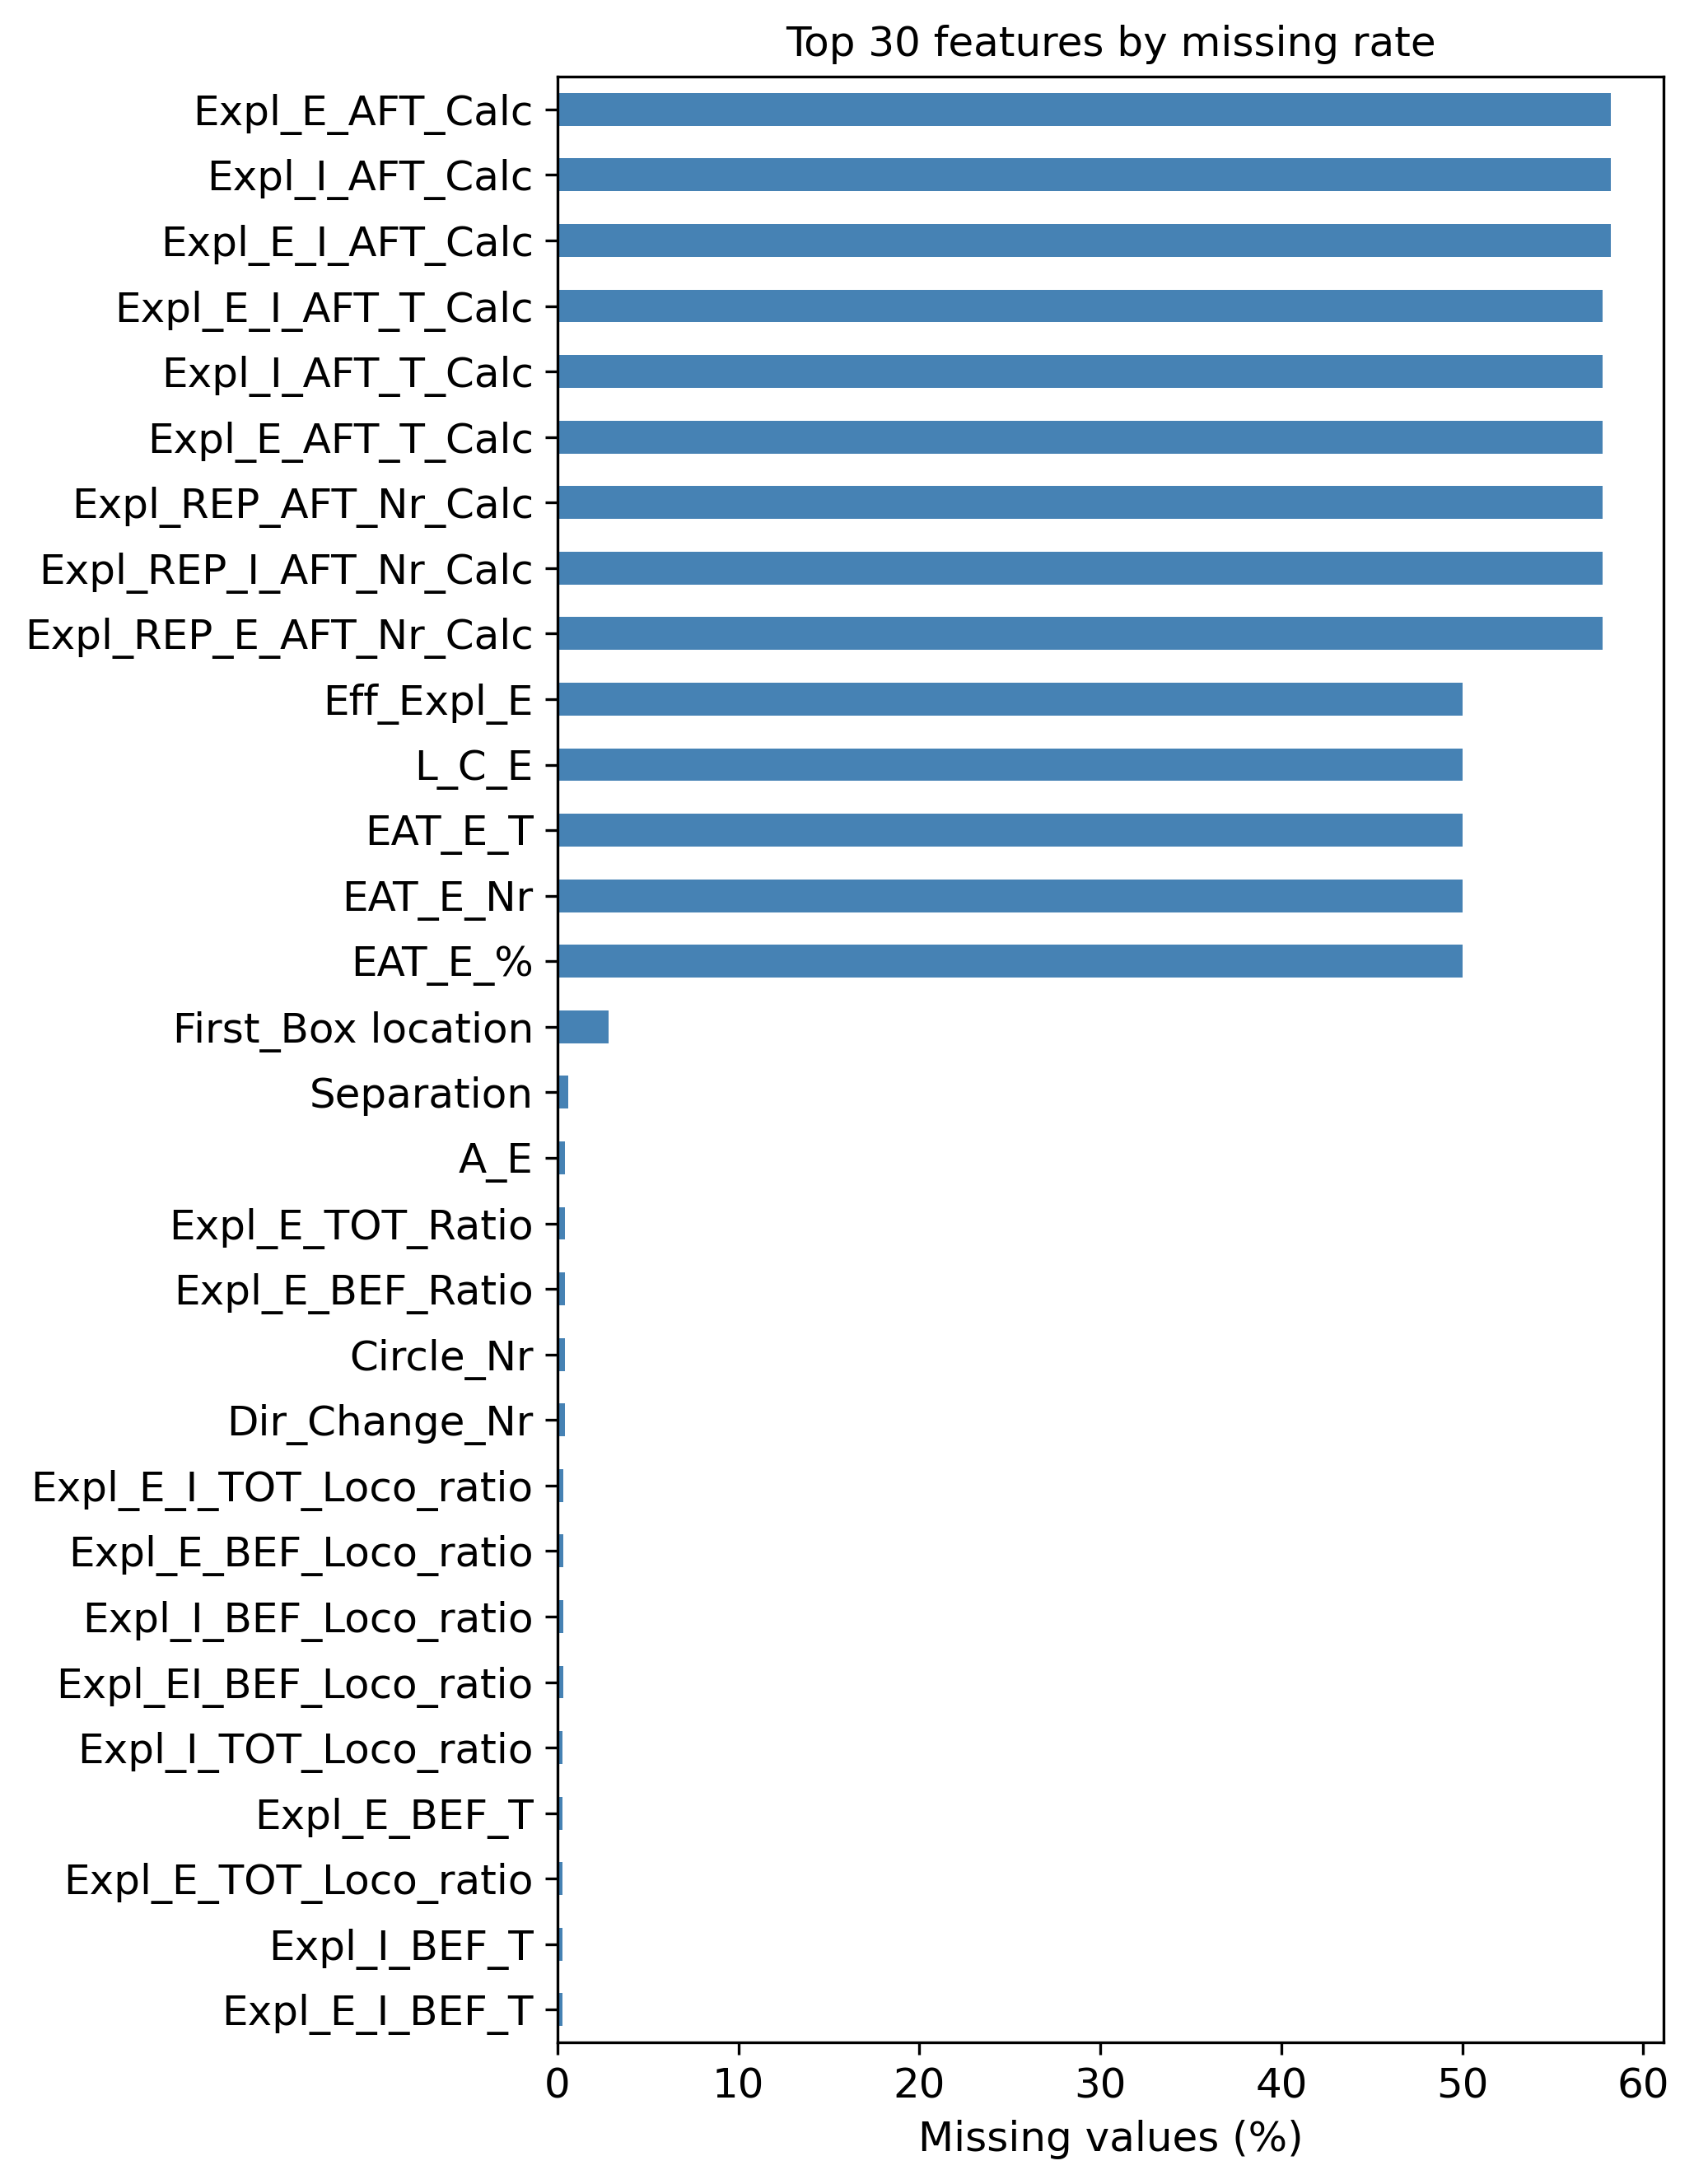

In [141]:
# Select the 30 features with the highest proportion of missing values
top30 = missing_pct.head(30)
# Create a horizontal bar plot showing the missingness of these top 30 features
plt.figure(figsize=(7, 9))
top30[::-1].plot.barh(color="steelblue") # Plot in reverse order for better readability
# Label the axes and add a title
plt.xlabel("Missing values (%)")
plt.title("Top 30 features by missing rate")
plt.tight_layout()
# Adjust layout and save the figure as a high-resolution PDF
plt.savefig(params['feature_missing_fig'], dpi=300)
# Display the plot
plt.show()
plt.close()

### Heatmap of Missing Data by Generation

To explore whether missingness patterns vary across experimental generations, we computed the percentage of missing values for the top 30 features within each generation. The resulting heatmap highlights generation-specific gaps in the data, which may reflect differences in experimental design, data collection protocols, or recording errors. This visualization can guide decisions about feature selection, imputation strategies, or data quality controls.

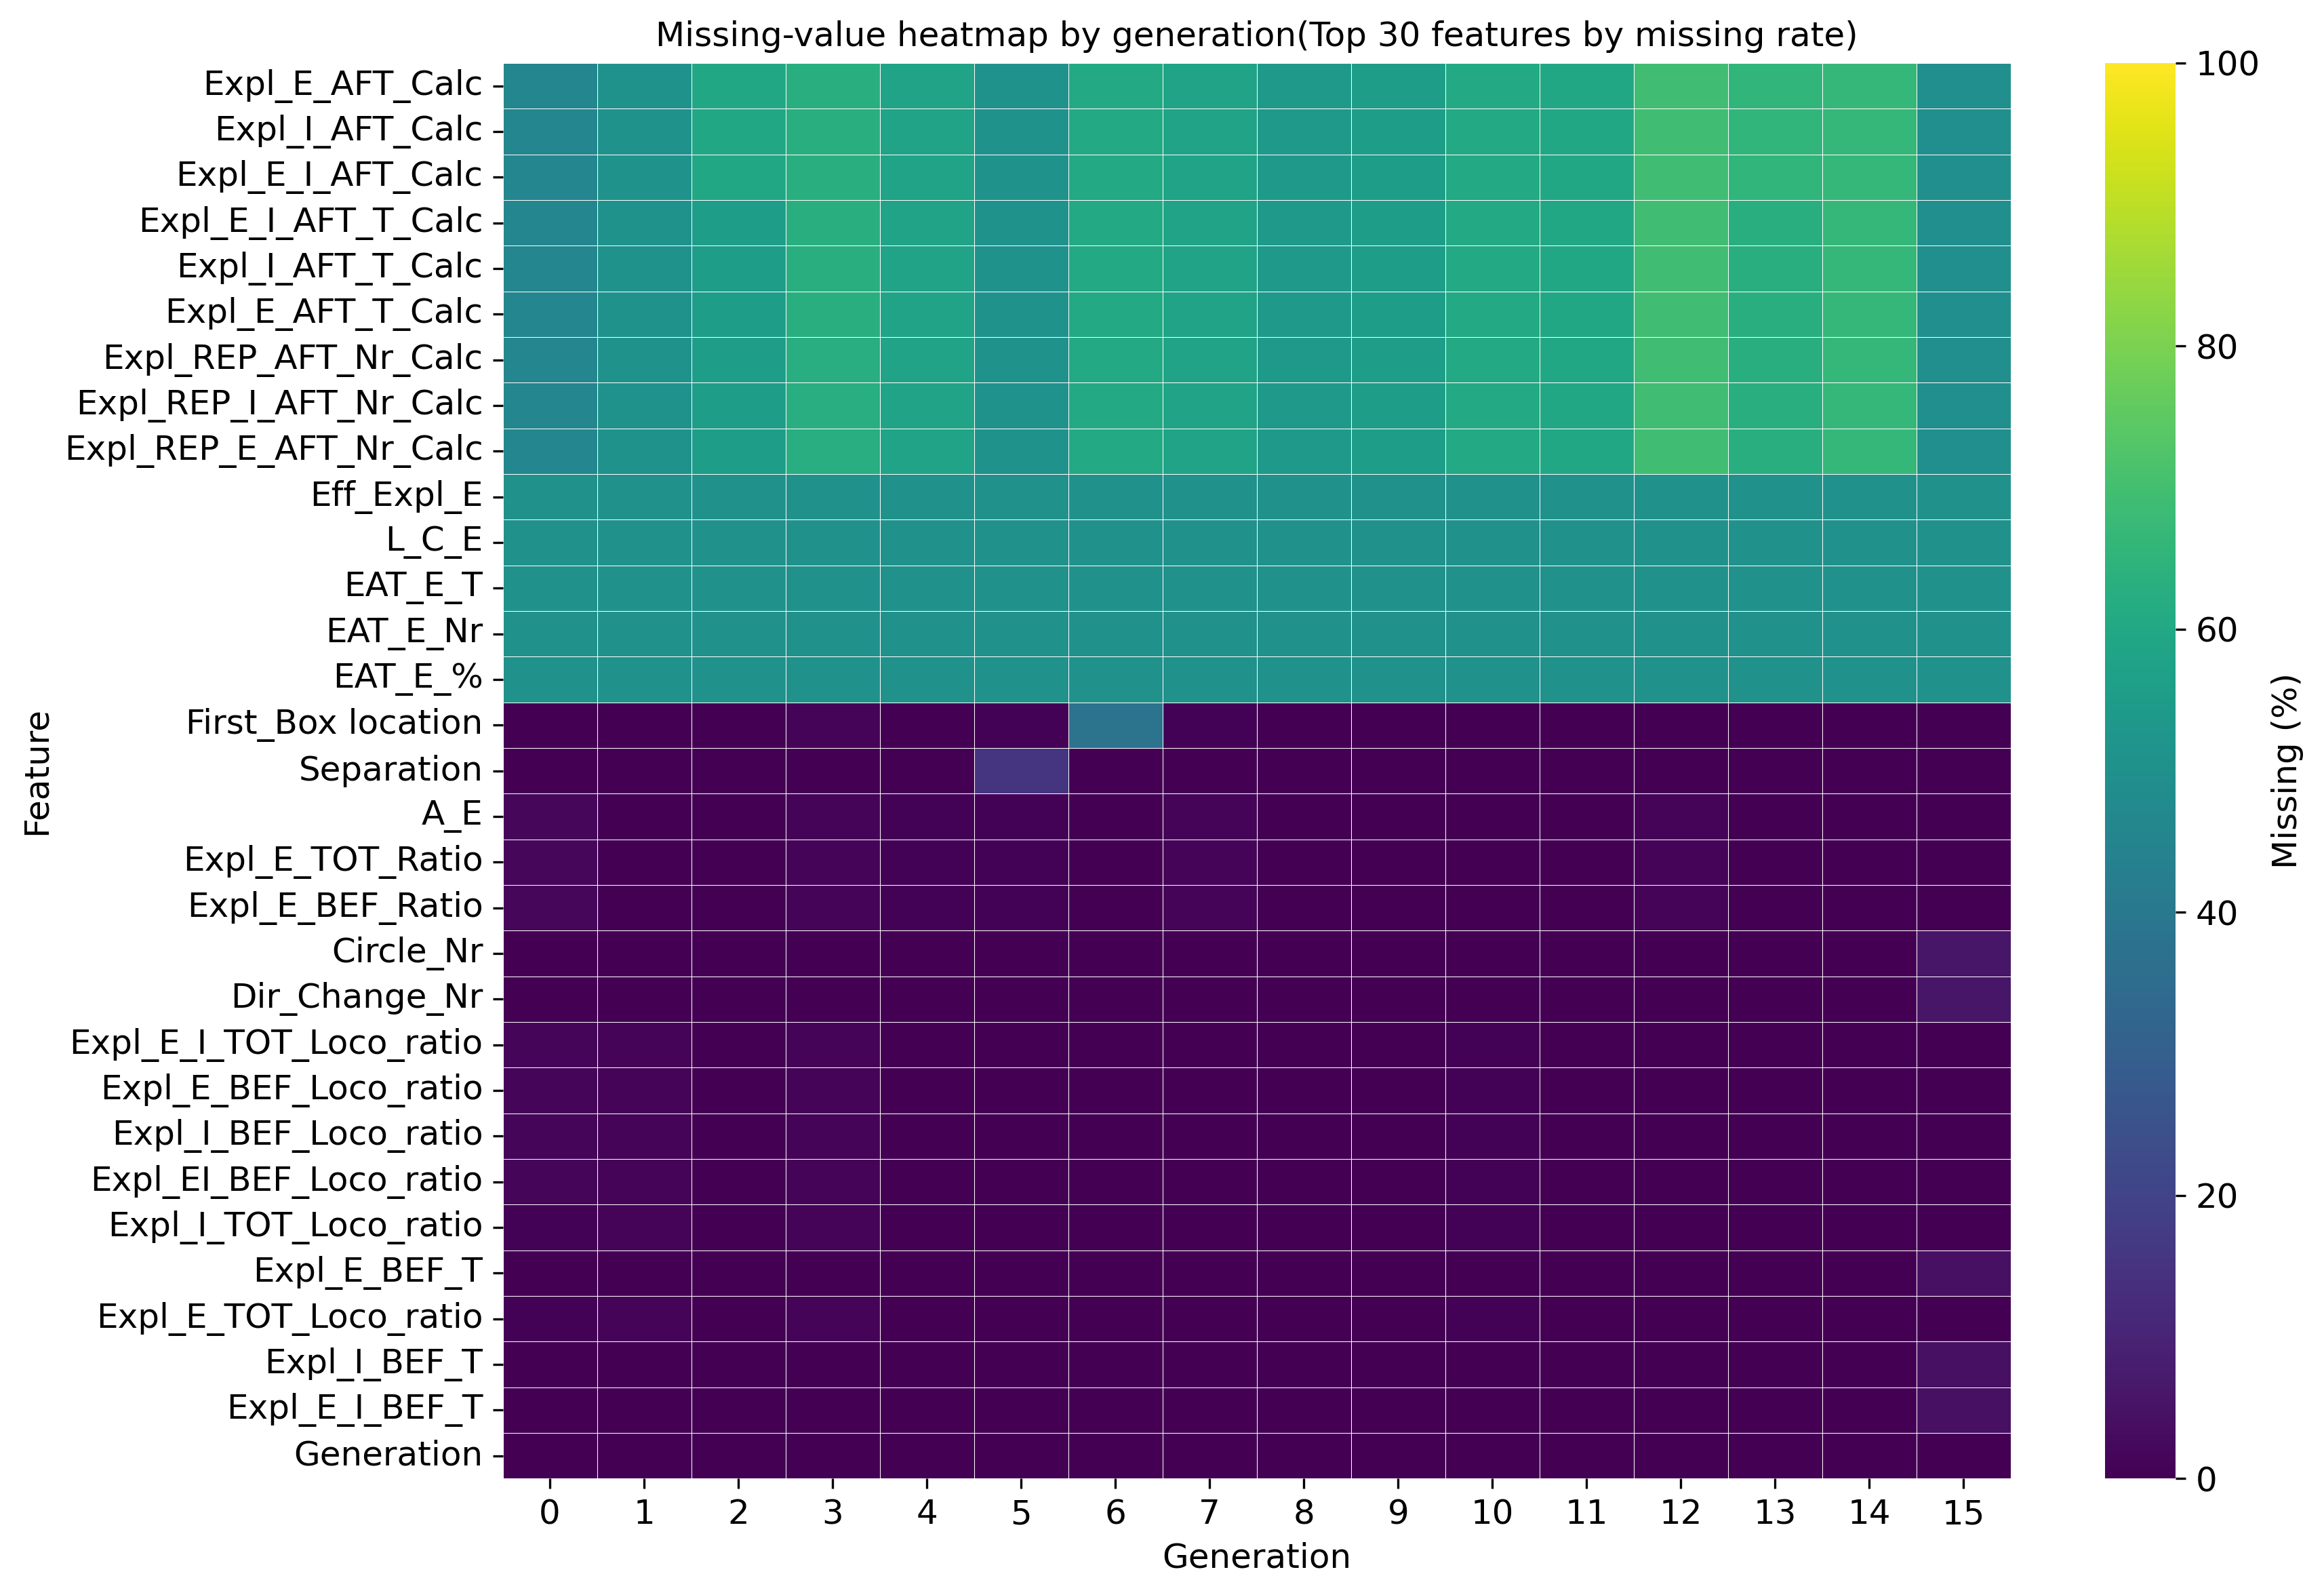

In [142]:
# Create a pivot table: rows = features, columns = generations
# For the top 30 features, compute the percentage of missing values per generation
miss_gen = (
    df.loc[:,list(top30.index)+ ["Generation"]].groupby("Generation")
      .apply(lambda x: x.isna().mean())          # Calculate missing ratio for each feature
      .T                                         # Transpose to make features as rows
      .mul(100)                                  # Convert to percentage
)
# Plot a heatmap of missing values across generations for top 30 features
plt.figure(figsize=(12, 8))
sns.heatmap(
    miss_gen,
    cmap="viridis",
    vmin=0, vmax=100,
    cbar_kws={"label": "Missing (%)"},
    linewidths=0.2
)
# Add labels and formatting
plt.title("Missing-value heatmap by generation(Top 30 features by missing rate)")
plt.xlabel("Generation")
plt.ylabel("Feature")
plt.tight_layout()
# Save the figure as high-resolution PDF
plt.savefig(params['feature_missing_heatmap'], dpi=300)
plt.show()
plt.close()


### Spearman Correlation Among Top Behavioral Features

To examine relationships between key behavioral readouts, we first excluded metadata and categorical variables (e.g., IDs, sex, group labels), then filtered the dataset to retain only numeric features with sufficient variance. From this cleaned subset, we selected the 30 most variable features and computed a Spearman correlation matrix to capture monotonic relationships between them. The heatmap provides insight into potential feature clusters, redundancies, or latent behavioral dimensions.

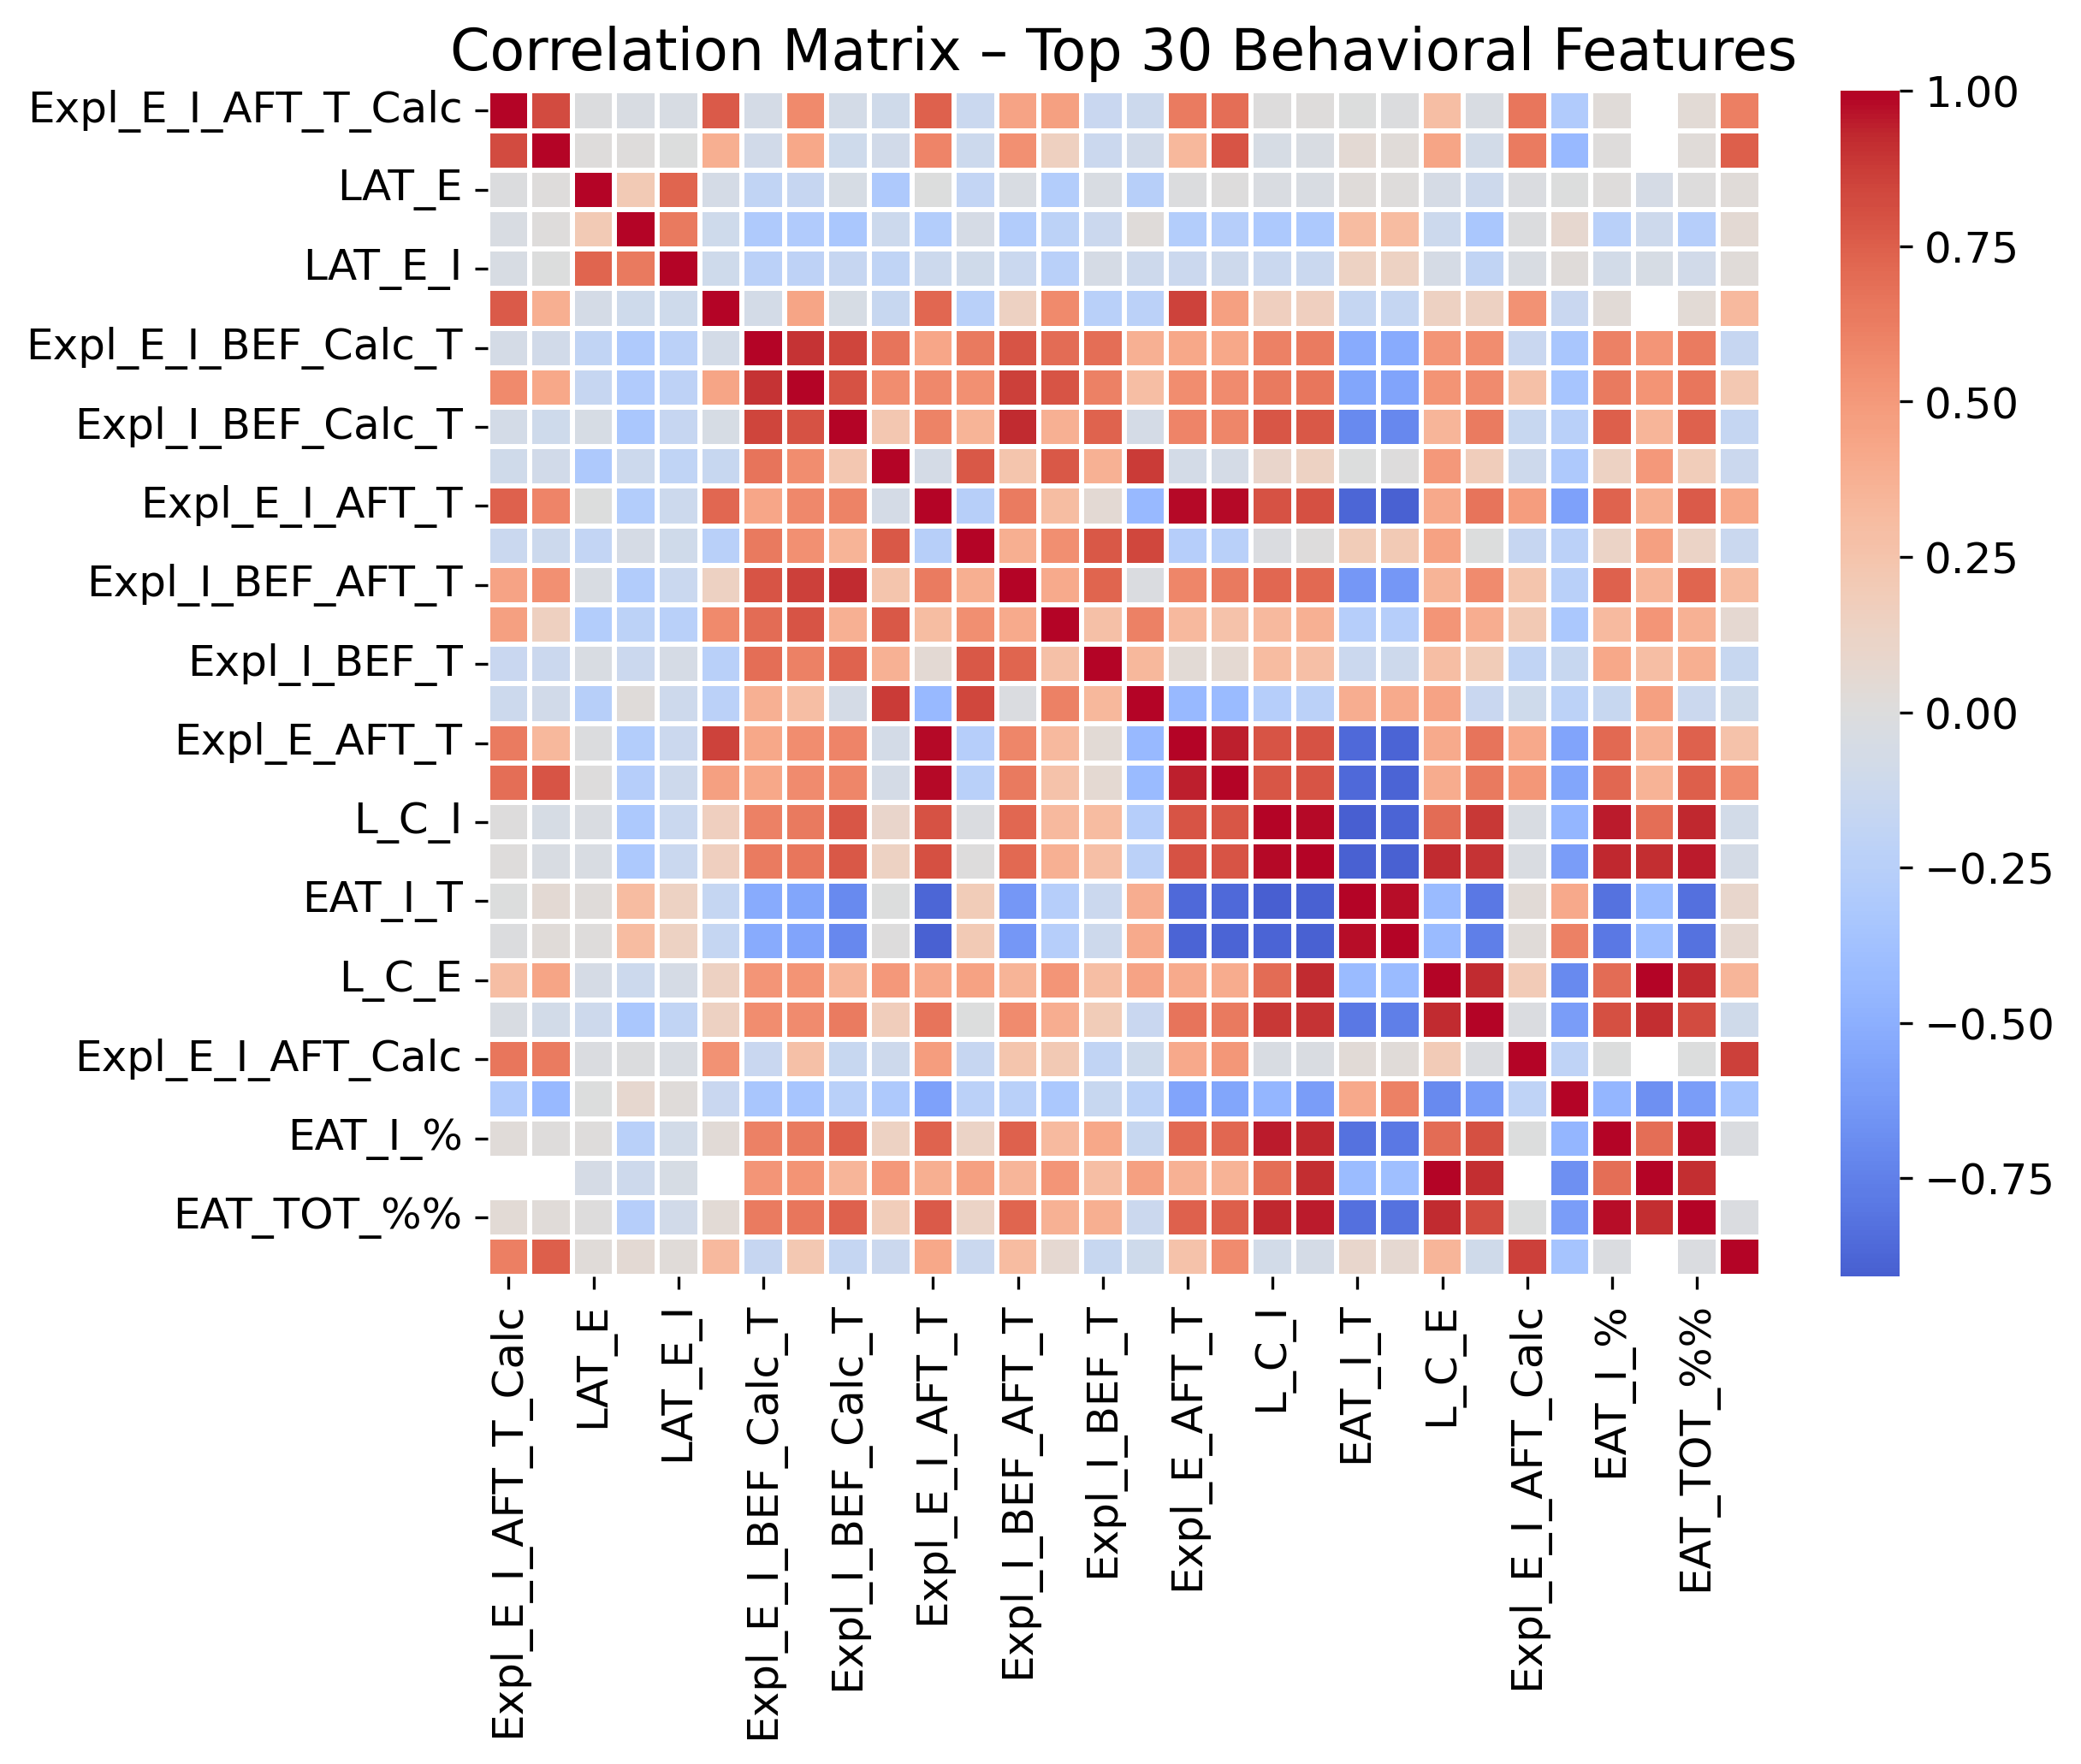

In [143]:
# Define a list of keywords related to identifiers and non-behavioral metadata
exclude_keywords = ['id', 'group', 'sex', 'trial', 'year', 'gen', 'rat', 'animal']
# Identify columns to exclude if they contain any of the keywords
exclude_columns = [col for col in df.columns if any(key in col.lower() for key in exclude_keywords)]
# Drop the identified non-behavioral columns from the dataset
df_filtered = df.drop(columns=exclude_columns, errors='ignore')

# Keep only numeric columns
df_numeric = df_filtered.select_dtypes(include='number')

# Drop columns with constant values or near-zero variance
df_numeric = df_numeric.loc[:, df_numeric.std() > 0.01]

# Select top 30 variables by standard deviation
top30_columns = df_numeric.std().sort_values(ascending=False).head(30).index
df_top30 = df_numeric[top30_columns]

# Plot the Spearman correlation matrix for the top 30 features
plt.figure(figsize=(8, 6))
sns.heatmap(df_top30.corr(method="spearman"), cmap="coolwarm", center=0, annot=False, fmt=".2f", linewidths=1)
plt.title("Correlation Matrix – Top 30 Behavioral Features", fontsize=16)
# Display the figure
plt.show()

### Generational Drift Analysis

To identify behavioral features that change systematically across generations, we computed Spearman correlations between each numeric feature and the generation number. This non-parametric approach captures monotonic trends regardless of linearity. After excluding non-numeric columns, we applied False Discovery Rate (FDR) correction to adjust for multiple hypothesis testing. The resulting ranked list of features (saved as gen_drift_spearman.csv) highlights traits that may reflect generational drift, such as adaptation, learned behavior, or methodological differences.


In [144]:
# separate metadata & numeric fesature matrix
meta_cols = ["RatID", "Generation"]                    # Add more metadata columns if needed
all_feat_cols = [c for c in df.columns if c not in meta_cols]

# Select only numeric and boolean columns (booleans are treated as numeric)
numeric_feat_cols = df[all_feat_cols].select_dtypes(
    include=["number", "boolean"]            # bool is OK
).columns.tolist()

# Optionally: print a few of the excluded (non-numeric) columns
dropped = set(all_feat_cols) - set(numeric_feat_cols)
if dropped:
    print(f"{len(dropped)} non-numeric columns skipped: {sorted(dropped)[:5]} ...")

# Compute Spearman correlation between Generation and each numeric feature
results = []
gen = df["Generation"].astype("float") 
for f in numeric_feat_cols:
    rho, p = spearmanr(gen, df[f], nan_policy="omit")
    results.append({"feature": f, "rho": rho, "p": p})
# Compile results and sort by absolute correlation
res = pd.DataFrame(results).sort_values("rho", key=np.abs, ascending=False)
# Apply FDR correction (Benjamini–Hochberg) for multiple testing
res["q"] = multipletests(res["p"], method="fdr_bh")[1]
# Save results to CSV
res.to_csv(params['gen_drift'], index=False)

9 non-numeric columns skipped: ['Animal', 'Date_Ambitus', 'GR_Sex', 'G_S', 'Group'] ...


In [145]:
display(res)

,feature,rho,p,q
1,Year,0.986711,0.000000e+00,0.000000e+00
75,Explored Area,0.337393,4.907274e-143,2.330955e-141
73,Circle_Nr,0.267544,2.649490e-88,8.390051e-87
72,Dir_Change_Nr,-0.259935,2.760852e-83,6.557024e-82
39,Expl_E_I_AFT_T_Calc,0.224896,2.137964e-27,1.068982e-26
...,...,...,...,...
34,Expl_E_AFT_T,0.004721,7.297346e-01,7.702754e-01
35,Expl_I_AFT_T,-0.000867,9.494264e-01,9.803859e-01
70,First_Box location,-0.000484,9.721196e-01,9.930254e-01
3,Trials,0.000000,1.000000e+00,1.000000e+00


### Generational Drift – Correlation Heatmap of Top 25 Features

To further investigate the structure of generational drift, we selected the top 25 features with the strongest correlations to generation. By aggregating feature values at the generation level (using medians), we reduced individual variability and highlighted population-level trends. A Spearman correlation heatmap reveals how these features co-vary across generations, suggesting potential latent dimensions or coordinated behavioral shifts over time.

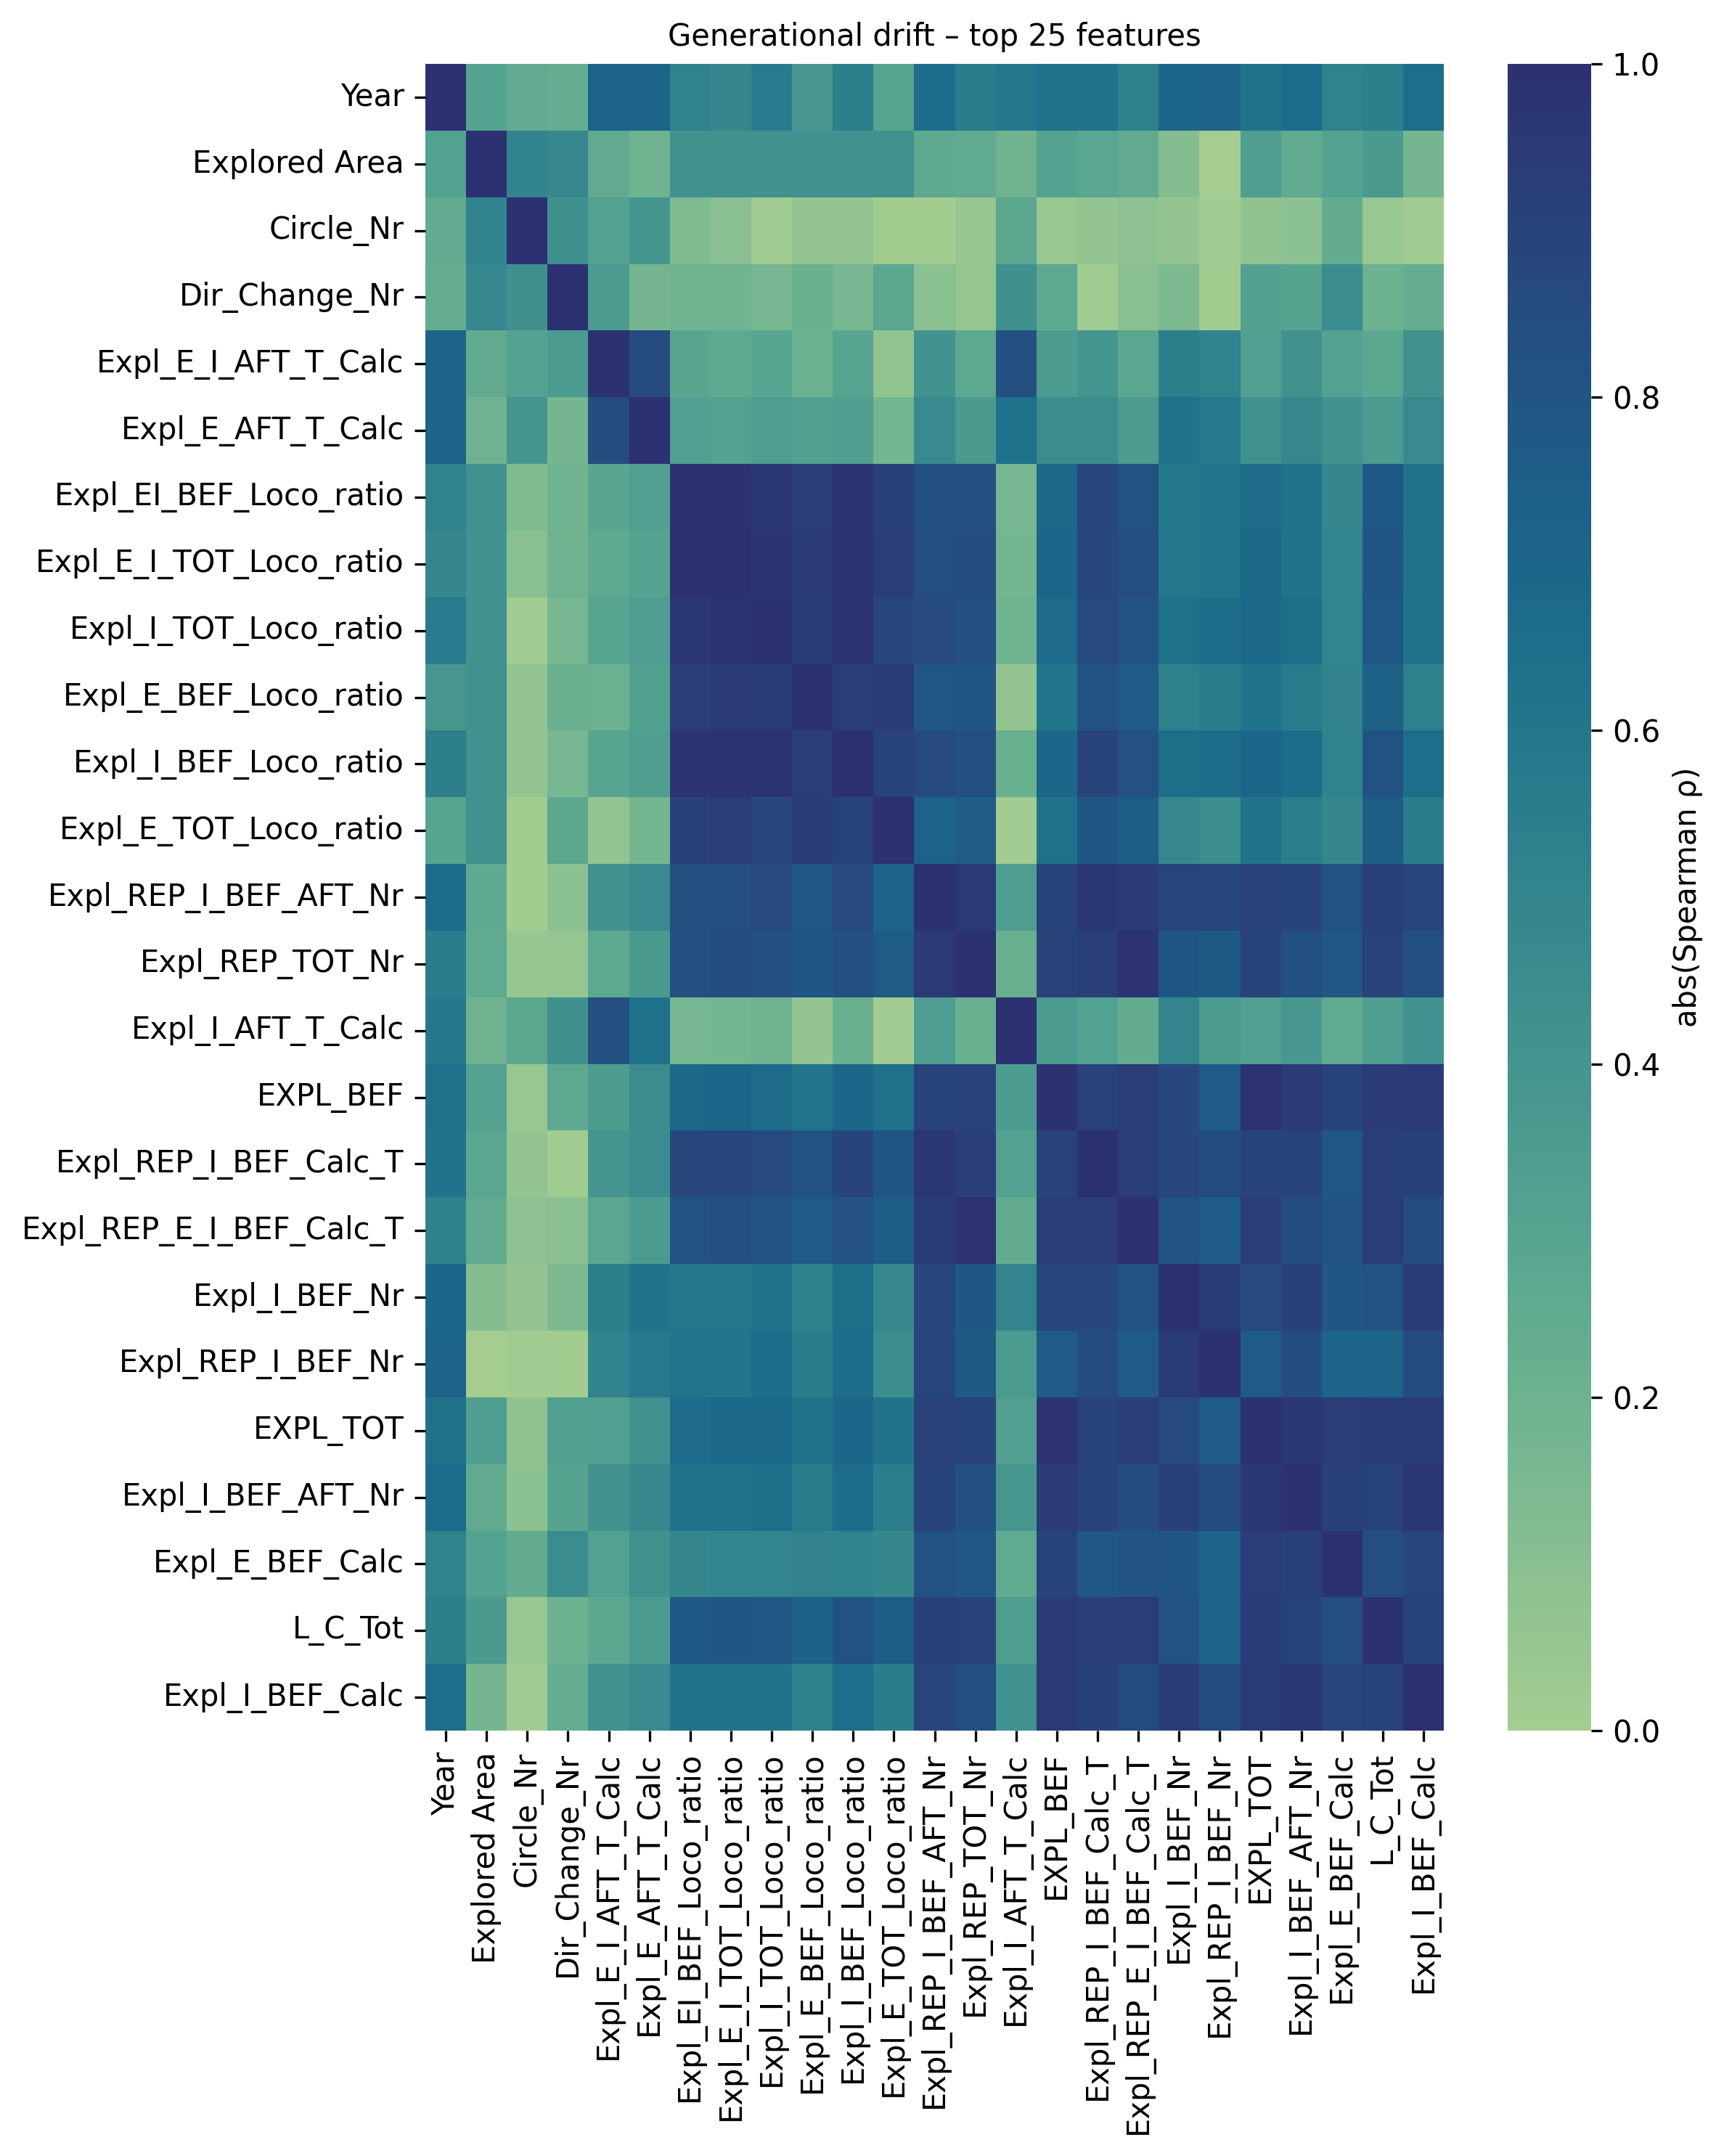

In [158]:
# Select the top 25 features showing the strongest generational drift
top25 = res.head(25)["feature"]
# Compute the Spearman correlation matrix between these top 25 features
# using their median values per generation (to smooth out noise)
corr_sub = (df.groupby("Generation")[top25]
              .median()
              .corr(method="spearman")          # feature × feature, quick normalisation
              .loc[top25, top25])

# Plot the absolute Spearman correlations as a heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(np.abs(corr_sub), cmap="crest", vmin=0, vmax=1,
            cbar_kws={"label": "abs(Spearman ρ)"})
# Add title and formatting
plt.title("Generational drift – top 25 features")
plt.tight_layout()
# Save the figure as a high-resolution PDF
plt.savefig(params['gen_drift_heatmap'], dpi=300)
plt.show()
plt.close()

### Generational Trends of Key Behavioral Metrics

To illustrate how specific behavioral traits evolve across generations, we plotted three representative metrics using a dual-axis line chart. The left y-axis shows latency (in milliseconds), while the right y-axis displays count-based and ratio-based metrics. Median values and interquartile ranges (25th to 75th percentiles) are visualized to highlight both central tendency and variability. This plot captures long-term trends that may reflect generational adaptation or procedural shifts in the experimental setup.

In [147]:
features_to_plot = [
    "Expl_E_AFT_T",          # latency, ms (large magnitude)
    "Expl_E_AFT_Nr",         # event count (low magnitude)
    "Expl_E_TOT_Loco_ratio"  # dimensionless ratio (very small)
]

df_line = (df.groupby("Generation")[features_to_plot]
             .agg(["median",
                   lambda x: x.quantile(0.25),
                   lambda x: x.quantile(0.75)])
             .rename(columns={"<lambda_0>": "q25", "<lambda_1>": "q75"})
             .reset_index())

df_line.columns = ["Generation"] + [
    f"{f}_{stat}" for f in features_to_plot for stat in ["med", "q25", "q75"]
]

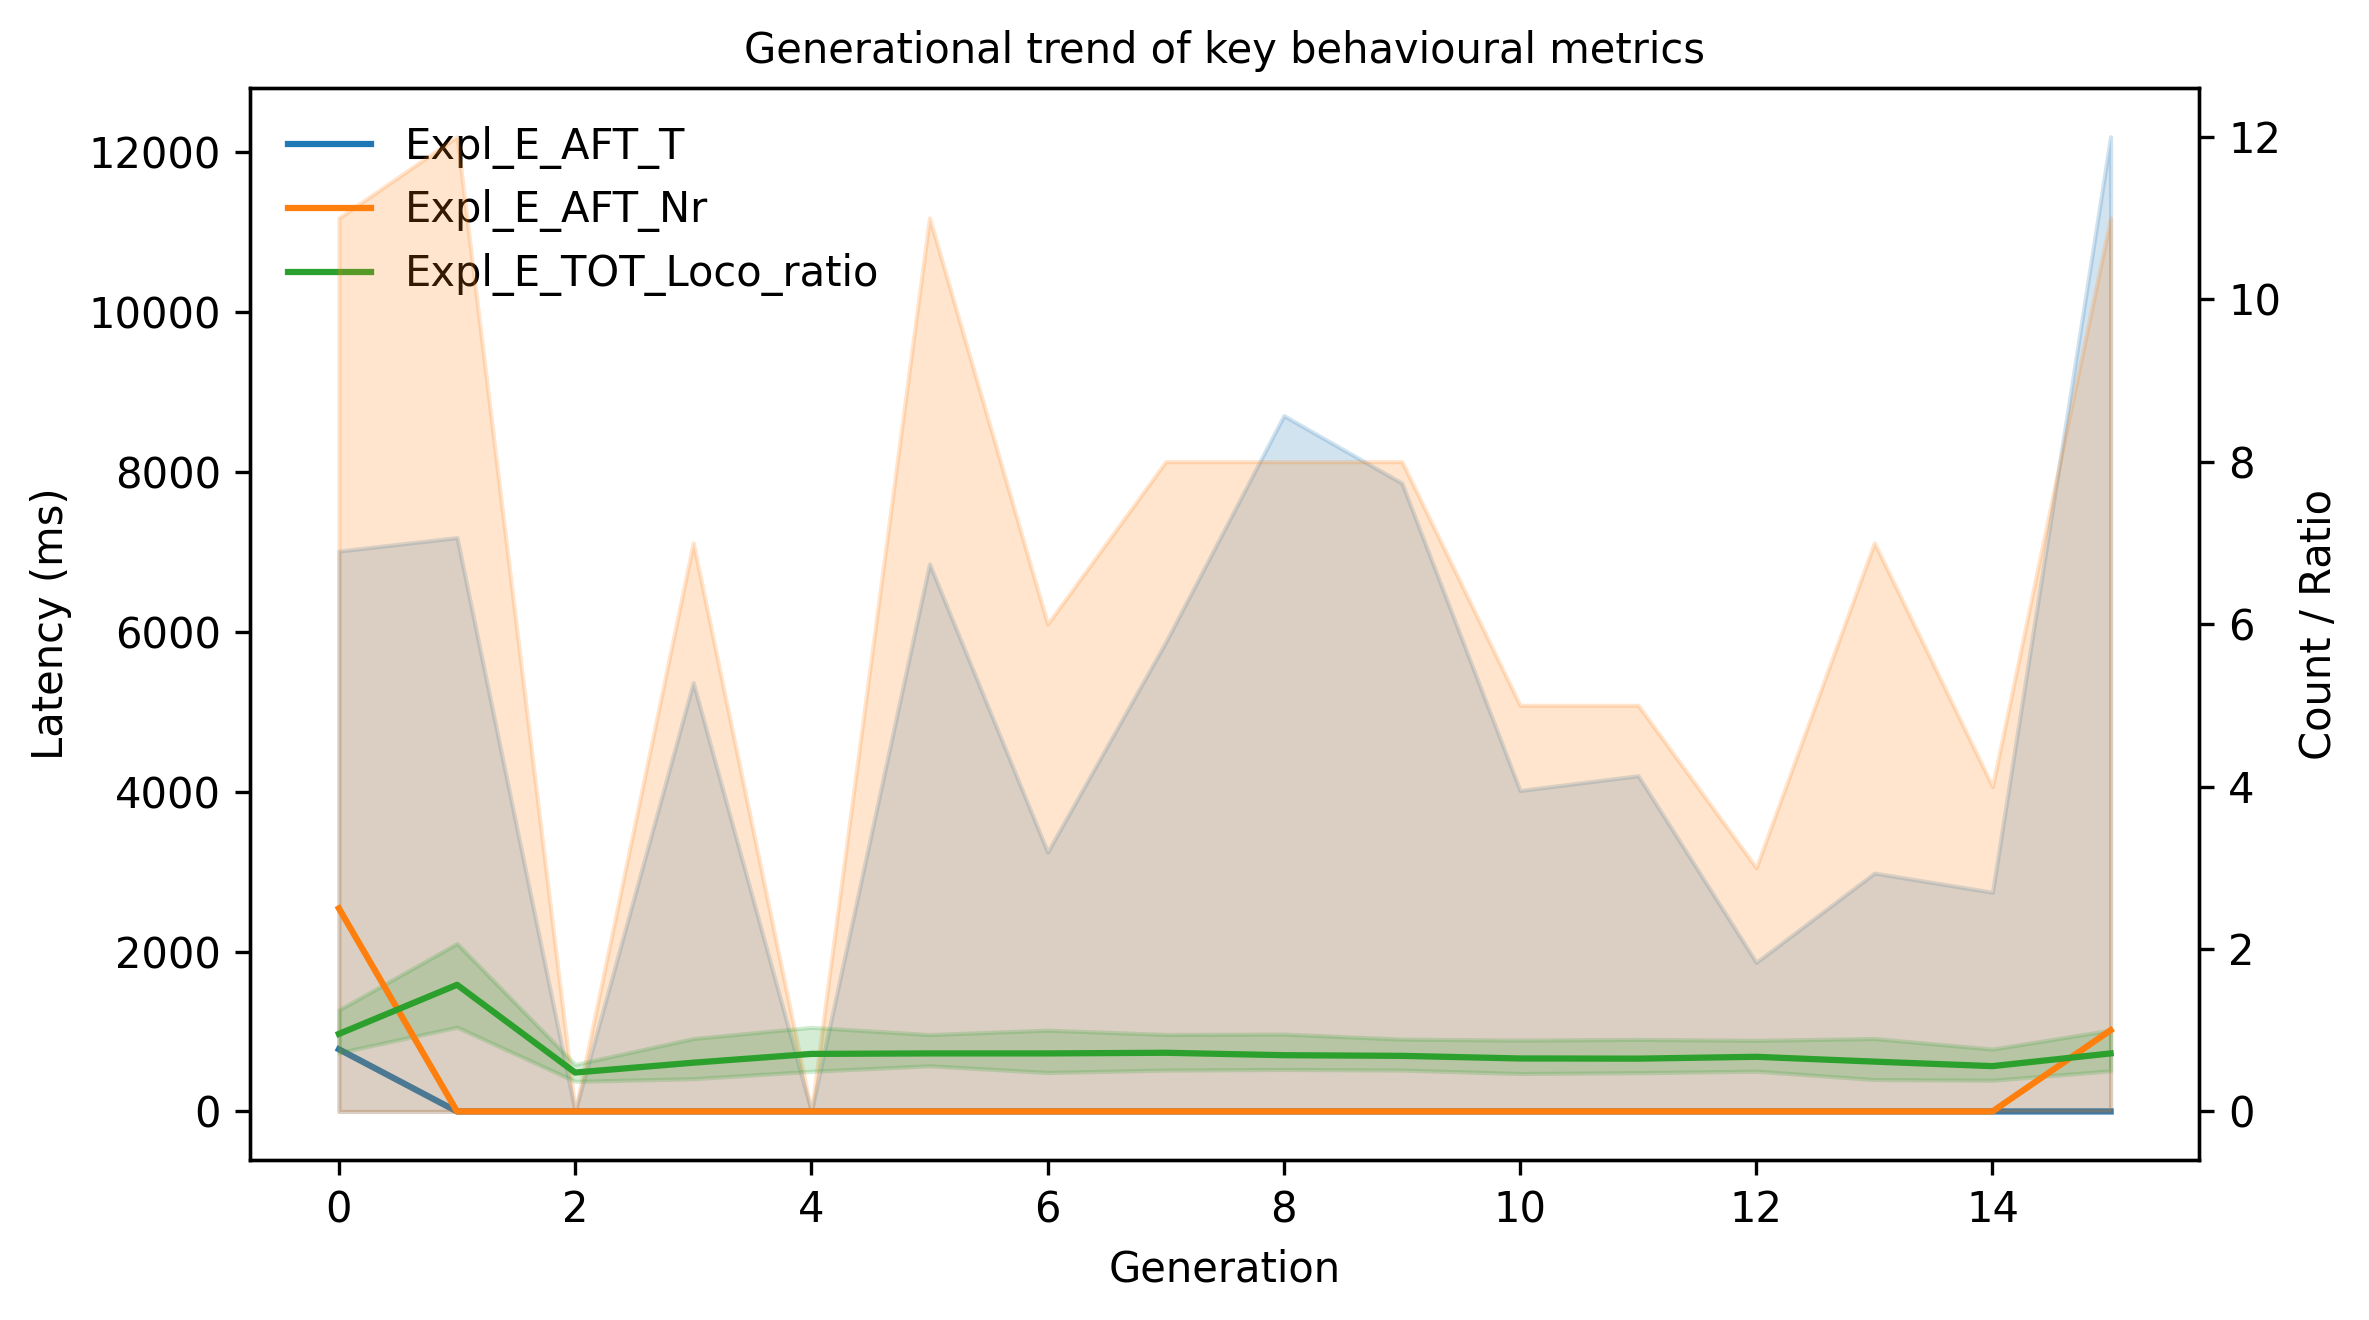

In [157]:
# Create a dual-axis plot to visualize multiple metrics with different scales
fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()  # Secondary y-axis

# Assign consistent colors using Matplotlib's default color cycle
col_map = dict(zip(features_to_plot, ["C0", "C1", "C2"]))

# LEFT y-axis: latency feature (typically larger values)
f_left = "Expl_E_AFT_T"
ax1.plot(df_line["Generation"], df_line[f"{f_left}_med"],
         label=f_left, color=col_map[f_left])
ax1.fill_between(df_line["Generation"],
                 df_line[f"{f_left}_q25"],
                 df_line[f"{f_left}_q75"],
                 alpha=0.20, color=col_map[f_left])
ax1.set_ylabel("Latency (ms)")
ax1.set_xlabel("Generation")

# RIGHT y-axis: count and ratio features (typically smaller scale)
for f in ["Expl_E_AFT_Nr", "Expl_E_TOT_Loco_ratio"]:
    ax2.plot(df_line["Generation"], df_line[f"{f}_med"],
             label=f, color=col_map[f])
    ax2.fill_between(df_line["Generation"],
                     df_line[f"{f}_q25"],
                     df_line[f"{f}_q75"],
                     alpha=0.20, color=col_map[f])

ax2.set_ylabel("Count / Ratio")

# Combine legends from both axes
handles, labels = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

ax1.legend(handles, labels, frameon=False, loc="upper left")

# Add plot title and finalize layout
ax1.set_title("Generational trend of key behavioural metrics")
plt.tight_layout()
plt.savefig(params['gen_drift_line'], dpi=300)
plt.show()
plt.close()

### Factorial ANOVA – Group × Sex × Year Effects

To evaluate whether behavioral outcomes differ across experimental groups, sexes, and years, we performed a factorial ANOVA on six key behavioral features. The model includes:
- Main effects: Group, Sex, Year
- Two-way interactions: Group × Year and Sex × Year
  
This analysis identifies which behavioral measures show statistically significant differences across subpopulations or temporal contexts. The results are compiled into a unified ANOVA table (final_anova_df) for further inspection and visualization.

In [149]:

# Drop rows where grouping variables are missing
df = df.dropna(subset=['GR_Sex', 'Year'])
# Normalize Sex information (lowercase for consistency)
df['Sex'] = df['Sex'].str.lower()
df['Group_Sex'] = df['GR_Sex'].str.lower()

# Define variables to test and corresponding feature names in the dataset
anova_targets = {
    'LOCO_TOT': 'Locomotion (Loco_TOT)',
    'LOCO_BEF': 'Locomotion frequency (LOCO_BEF)',
    'EXPL_TOT': 'Exploration (Expl_TOT)',
    'Expl_E_I_BEF_Nr': 'Exploration frequency (Expl_BEF)',
    'L_C': 'Learning capacity (L_C)',
    'E_E': 'Effective exploration ratio (E_E)'
}

# Initialize a list to collect ANOVA results
anova_results = []

# Perform two-way factorial ANOVA for each target variable
# Including main effects and interactions with Year
for feature, description in anova_targets.items():
    formula = f"{feature} ~ C(Group) + C(Sex) + C(Year) + C(Group):C(Year) + C(Sex):C(Year)"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    # Annotate results with feature description and variable name
    anova_table["Feature"] = description
    anova_table["Variable"] = anova_table.index
    anova_results.append(anova_table.reset_index(drop=True))

# Combine results into a single DataFram
final_anova_df = pd.concat(anova_results, ignore_index=True)

### ANOVA Summary Table (Formatted for Readability)

The raw factorial ANOVA results are reformatted into a clean summary table. Only the main effects and relevant two-way interactions are retained:
- Gr: Experimental Group
- Sex: Biological Sex
- Year: Testing Year
- Gr/Y: Group × Year interaction
- Sex/Y: Sex × Year interaction

Each cell shows the F-statistic along with the associated p-value, helping to quickly identify which variables are significantly influenced by group, sex, year, or their interactions. This format is well-suited for publication or supplementary tables.

In [150]:
# Create a copy of the original ANOVA results to preserve the source
df_anova = final_anova_df.copy()

# Define a mapping from raw ANOVA variable terms to simplified labels
label_map = {
    'C(Group)': 'Gr',
    'C(Sex)': 'Sex',
    'C(Year)': 'Year',
    'C(Group):C(Year)': 'Gr/Y',
    'C(Sex):C(Year)': 'Sex/Y'
}

# Filter the DataFrame to retain only the terms of interest
df_anova = df_anova[df_anova['Variable'].isin(label_map.keys())]

# Create a new column for simplified effect labels
df_anova['Effect'] = df_anova['Variable'].map(label_map)

# Format the F and p-values into a readable string
df_anova['F(p)'] = df_anova.apply(
    lambda row: f"{row['F']:.2f} (p < {row['PR(>F)']:.4f})", axis=1
)

# Pivot the table so each effect is a column and each feature is a row
table_formatted = df_anova.pivot(index='Feature', columns='Effect', values='F(p)')

# Reorder columns to match desired output
ordered_cols = ['Gr', 'Sex', 'Year', 'Gr/Y', 'Sex/Y']
table_formatted = table_formatted.reindex(columns=ordered_cols)
display(table_formatted)

Effect,Gr,Sex,Year,Gr/Y,Sex/Y
Feature,,,,,
Effective exploration ratio (E_E),102.58 (p < 0.0000),3.69 (p < 0.0547),19.32 (p < 0.0000),12.56 (p < 0.0000),3.00 (p < 0.0063)
Exploration (Expl_TOT),293.82 (p < 0.0000),4.12 (p < 0.0425),41.56 (p < 0.0000),21.92 (p < 0.0000),3.52 (p < 0.0018)
Exploration frequency (Expl_BEF),67.93 (p < 0.0000),25.22 (p < 0.0000),34.10 (p < 0.0000),12.19 (p < 0.0000),2.76 (p < 0.0112)
Learning capacity (L_C),261.45 (p < 0.0000),2.80 (p < 0.0943),28.40 (p < 0.0000),11.74 (p < 0.0000),2.06 (p < 0.0545)
Locomotion (Loco_TOT),147.16 (p < 0.0000),94.49 (p < 0.0000),14.02 (p < 0.0000),12.63 (p < 0.0000),1.70 (p < 0.1163)
Locomotion frequency (LOCO_BEF),37.25 (p < 0.0000),44.34 (p < 0.0000),22.36 (p < 0.0000),2.96 (p < 0.0069),5.35 (p < 0.0000)


### Trial-to-Trial Consistency (Spearman Correlation) by Task

In this analysis, we evaluate the internal consistency of each behavioral feature between the first and second trial of two distinct tasks (Task1 = Trials 1–2, Task2 = Trials 3–4).
Using Spearman rank correlation, we compute reproducibility for each numeric variable and summarize reliability across animals and features.

In [151]:
# Build a unique animal identifier by combining generation, number, and group
df["Animal_ID"] = (df["Generation"].astype(str) + "_" +
                   df["NR"].astype(str) + "_" +
                   df["Group"].astype(str)
                    )
# Map trial numbers to task labels (Task1: Trials 1–2, Task2: Trials 3–4)
df["Task"] = df["Trials"].map({1: "Task1", 2: "Task1",
                               3: "Task2", 4: "Task2"
                                })

# Select numeric columns, excluding metadata
numeric_cols = [ c for c in df.select_dtypes(include="number").columns
                 if c not in {"Generation", "NR", "Trials"}
               ]

In [152]:
results = []

# Loop over Task1 and Task2 separately
for task in ["Task1", "Task2"]:
    sub = df[df["Task"] == task]

    # Keep only animals that completed both trials of the task
    enough = sub.groupby("Animal_ID")["Trials"].nunique().eq(2)
    sub = sub[sub["Animal_ID"].isin(enough[enough].index)].copy()

    # Pivot to wide format: one row per animal, columns = trial numbers
    wide = (
        sub.pivot_table(index="Animal_ID", columns="Trials", values=numeric_cols)
           .dropna()  # Exclude animals with any missing trial data
    )
    if task=="Task1":
        op1=1
        op2=2
    else:
        op1=3
        op2=4
        

    # Compute Spearman correlation for each variable across trial 1 vs 2
    for var in numeric_cols:
        try:
            r, p = spearmanr(wide[var][op1], wide[var][op2])
            results.append({
                "Task": task,
                "Variable": var,
                "rho_spearman": r,
                "pvalue": p,
                "n_animals": wide.shape[0]
            })
        except Exception as e:
            print(f"{var} ({task}) – skipped: {e}")

# Compile results into a DataFrame and sort
spearman = pd.DataFrame(results).sort_values(
    ["Task", "rho_spearman"], ascending=[True, False]
)

# Export raw Spearman correlations
spearman.to_csv(params['spearman_result'], index=False)

EAT_E_Nr (Task2) – skipped: 'EAT_E_Nr'
EAT_E_% (Task2) – skipped: 'EAT_E_%'
EAT_E_T (Task2) – skipped: 'EAT_E_T'
L_C_E (Task2) – skipped: 'L_C_E'
Eff_Expl_E (Task2) – skipped: 'Eff_Expl_E'


In [153]:
# FDR correction within each task ---
def add_q_values(df):
    df = df.copy()
    _, q, _, _ = multipletests(df["pvalue"], method="fdr_bh")
    df["q"] = q
    return df

# Apply FDR correction per task
spearman = (
            spearman
            .groupby("Task", group_keys=False)
            .apply(add_q_values)
        )

In [154]:
# Compute summary statistics
summary = (
            spearman
            .assign(reliable=lambda d: d["rho_spearman"].abs() >= 0.6)
            .groupby("Task")
            .agg(
                median_rho=("rho_spearman", "median"),
                IQR_rho=("rho_spearman", lambda x: f"{x.quantile(.25):.2f} – {x.quantile(.75):.2f}"),
                n_vars=("Variable", "count"),
                n_reliable=("reliable", "sum")
            )
        )
print("\n===  Task-level Spearman summary  ===")
print(summary)


===  Task-level Spearman summary  ===
       median_rho      IQR_rho  n_vars  n_reliable
Task                                              
Task1    0.437414  0.32 – 0.59      93          17
Task2    0.401698  0.30 – 0.51      88           9


In [155]:
# Display top and bottom 5 features per task
for task in spearman["Task"].unique():
    print(f"\n===  {task}: TOP 5  ===")
    print(
        spearman[spearman["Task"] == task]
        .nlargest(5, "rho_spearman")
        [["Variable", "rho_spearman", "q"]]
        .to_string(index=False)
    )

    print(f"\n===  {task}: BOTTOM 5  ===")
    print(
        spearman[spearman["Task"] == task]
        .nsmallest(5, "rho_spearman")
        [["Variable", "rho_spearman", "q"]]
        .to_string(index=False)
    )


===  Task1: TOP 5  ===
     Variable  rho_spearman   q
         Year      1.000000 NaN
Explored Area      1.000000 NaN
    Circle_Nr      0.963725 NaN
     LOCO_TOT      0.873278 NaN
     LOCO_BEF      0.829670 NaN

===  Task1: BOTTOM 5  ===
        Variable  rho_spearman   q
Box_REP_I_BEF_Nr     -0.139366 NaN
         EAT_I_T     -0.112948 NaN
 Expl_I_AFT_Calc     -0.085400 NaN
           L_C_I     -0.049587 NaN
             A_E     -0.038781 NaN

===  Task2: TOP 5  ===
               Variable  rho_spearman   q
                   Year      1.000000 NaN
          Explored Area      0.869937 NaN
               LOCO_TOT      0.705161 NaN
Expl_E_I_TOT_Loco_ratio      0.700009 NaN
  Expl_I_TOT_Loco_ratio      0.689984 NaN

===  Task2: BOTTOM 5  ===
          Variable  rho_spearman   q
First_Box location      0.026262 NaN
  Expl_E_BEF_Ratio      0.111882 NaN
  Expl_E_TOT_Ratio      0.157526 NaN
             LAT_E      0.158450 NaN
       Lat_Tot_Log      0.158450 NaN
